In [1]:
import numpy as np
import pandas as pd
from arch import arch_model
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt 
%matplotlib inline 
plt.style.use("seaborn");

# Data

In [2]:
data = pd.read_excel(r"C:\Users\USER\Python Programme\uni\fe_assignment\spot_future.xlsx", index_col=0, na_values=['-'], sheet_name=["deviation and cost"])
# df_return=(data['deviation and cost']['Spot'].pct_change()*100)
# spot = data['future_spot']['spot']
# df_return.plot();
future_spot = data['deviation and cost']
# future = data['future_test']
# dates = future_spot.index
spot_return = np.log(future_spot['Spot'].shift(1) / future_spot['Spot']).dropna(axis=0)

In [3]:
data = spot_return

# ADF Test

In [4]:
result = adfuller(data)
adf_statistic = result[0]  # Extract ADF statistic
p_value = result[1]  # Extract p-value
critical_values = result[4]  # Extract critical values

# Print ADF test results
print("ADF Statistic: {:.4f}".format(adf_statistic))
print("p-value: {:.4f}".format(p_value))
print("Critical Values (at different confidence levels):")
for key, value in critical_values.items():
    print("\t{}: {:.4f}".format(key, value))

ADF Statistic: -74.2518
p-value: 0.0000
Critical Values (at different confidence levels):
	1%: -3.4316
	5%: -2.8621
	10%: -2.5671


# Best GARCH Model Selection

In [21]:
from arch.univariate import ConstantMean, GARCH, Normal

In [48]:
def garch(p, q):
    am = ConstantMean(data, rescale=False)
    am.volatility = GARCH(p=p,q=q)
    am.distribution = Normal()
    res = am.fit()
    return res.aic

In [ ]:
total_p, total_q = 6,6
aics = {}
for p in range(1, total_p):
    for q in range(1, total_q):
        aics[f"({p}, {q})"] = garch(p, q)
aics

In [55]:
df_aic = pd.DataFrame(aics, index=["AIC"]).T
df_aic.index.name = "(p, q)"
df_aic.idxmin()

AIC    (2, 5)
dtype: object

In [25]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                   Spot   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7760.02
Distribution:                  Normal   AIC:                           15538.0
Method:            Maximum Likelihood   BIC:                           15597.5
                                        No. Observations:                 5449
Date:                Mon, Jun 19 2023   Df Residuals:                     5448
Time:                        20:04:34   Df Model:                            1
                                  Mean Model                                  
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
mu            -0.0309  1.305e-02     -2.365  1.805e-02 [-5.642e-02,-5.280e-03]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0282  1.506e-02      1.871  6.138e-02 [-1.343e-03,5.768e-02]
alpha[1]       0.0438  2.607e-02      1.681  9.270e-02 [-7.265e-03,9.495e-02]
alpha[2]       0.0615  3.815e-02      1.613      0.107   [-1.325e-02,  0.136]
beta[1]        0.1910      0.585      0.326      0.744      [ -0.956,  1.338]
beta[2]        0.1352      0.388      0.348      0.728      [ -0.626,  0.896]
beta[3]        0.1196      0.309      0.387      0.699      [ -0.486,  0.725]
beta[4]        0.2465      0.198      1.245      0.213      [ -0.141,  0.635]
beta[5]        0.1784      0.433      0.412      0.680      [ -0.670,  1.027]
=============================================================================

Covariance estimator: robust
"""

# ARCH-LM test

In [83]:
model = arch_model(data, vol='GARCH', rescale=False, p=2, q=5, dist="Normal")
results = model.fit()

# Perform ARCH-LM test on standardized residuals
lm_test = results.arch_lm_test(lags=10)  # Perform ARCH-LM test with 10 lags

# Print ARCH-LM test results
print(f"Null Hypothesis: {lm_test.null}")
print(f"Alternative Hypothesis: {lm_test.alternative}")
print("ARCH-LM Test Statistic: {:.4f}".format(lm_test.stat))
print("p-value: {:.4f}".format(lm_test.pval))
print(f'Conclusion: {"Failed to reject the null hypothesis, the error variance is homoscedastic" if lm_test.pval >= 0.05 else "Reject the null hypothesis, the error variance is heteroscedastic, so GARCH model may be suitable"}')

Iteration:      1,   Func. Count:     11,   Neg. LLF: 140591649624.0085
Iteration:      2,   Func. Count:     29,   Neg. LLF: 4652.051268535111
Iteration:      3,   Func. Count:     45,   Neg. LLF: 246866322881.90134
Iteration:      4,   Func. Count:     65,   Neg. LLF: 6570894052.225989
Optimization terminated successfully    (Exit mode 0)
            Current function value: -17332.76691173524
            Iterations: 5
            Function evaluations: 75
            Gradient evaluations: 4
Null Hypothesis: Residuals are homoskedastic.
Alternative Hypothesis: Residuals are conditionally heteroskedastic.
ARCH-LM Test Statistic: 290.1320
p-value: 0.0000
Conclusion: Reject the null hypothesis, the error variance is heteroscedastic, so GARCH model may be suitable


# GARCH Model

Iteration:      1,   Func. Count:     11,   Neg. LLF: 140591649624.0085
Iteration:      2,   Func. Count:     29,   Neg. LLF: 4652.051268535111
Iteration:      3,   Func. Count:     45,   Neg. LLF: 246866322881.90134
Iteration:      4,   Func. Count:     65,   Neg. LLF: 6570894052.225989
Optimization terminated successfully    (Exit mode 0)
            Current function value: -17332.76691173524
            Iterations: 5
            Function evaluations: 75
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     11,   Neg. LLF: 140591649624.0085
Iteration:      2,   Func. Count:     29,   Neg. LLF: 4652.051268535111
Iteration:      3,   Func. Count:     45,   Neg. LLF: 246866322881.90134
Iteration:      4,   Func. Count:     65,   Neg. LLF: 6570894052.225989
Optimization terminated successfully    (Exit mode 0)
            Current function value: -17332.76691173524
            Iterations: 5
            Function evaluations: 75
            Gradient evaluations: 4


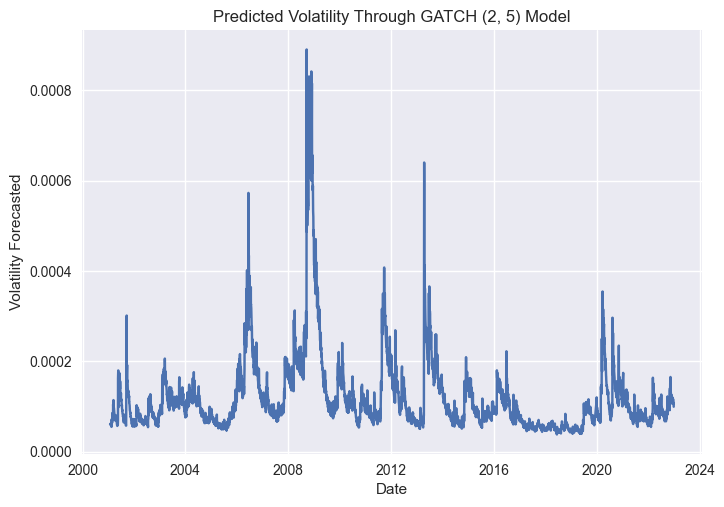

In [84]:
results = model.fit()
res = model.fit()
# Print model summary

# Access model parameters
mu = res.params['mu']  # Mean return estimate
omega = res.params['omega']  # GARCH(0) coefficient estimate
alpha = res.params['alpha[1]']  # GARCH(1) coefficient estimate
beta = res.params['beta[1]']  # ARCH(1) coefficient estimate

# Generate forecasted conditional variances
forecasts = res.forecast(start=0, reindex=True)  # Forecast conditional variances for the entire data

# Access forecasted conditional variances
cond_variances = forecasts.variance.values  # Array of forecasted conditional variances
fig, ax = plt.subplots()
ax.plot(future_spot.index[1:], cond_variances.flatten());
ax.set(**{
    "xlabel" : "Date",
    "ylabel": "Volatility Forecasted",
    "title": "Predicted Volatility Through GATCH (2, 5) Model"
});

In [85]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                   Spot   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                17332.8
Distribution:                  Normal   AIC:                          -34647.5
Method:            Maximum Likelihood   BIC:                          -34588.1
                                        No. Observations:                 5449
Date:                Mon, Jun 19 2023   Df Residuals:                     5448
Time:                        21:18:08   Df Model:                            1
                                   Mean Model                                  
===============================================================================
                  coef    std err          t      P>|t|        95.0% Conf. Int.
-------------------------------------------------------------------------------
mu         -3.0973e-04  1.309e-04     -2.367  1.793e-02 [-5.662e-04,-5.326e-05]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      2.3715e-06  4.866e-14  4.874e+07      0.000 [2.371e-06,2.371e-06]
alpha[1]       0.0500  2.600e-02      1.923  5.449e-02  [-9.635e-04,  0.101]
alpha[2]       0.0500  1.267e-02      3.947  7.919e-05 [2.517e-02,7.483e-02]
beta[1]        0.1760      0.349      0.505      0.614     [ -0.508,  0.860]
beta[2]        0.1760      0.559      0.315      0.753     [ -0.919,  1.271]
beta[3]        0.1760      0.300      0.586      0.558     [ -0.412,  0.764]
beta[4]        0.1760      0.260      0.678      0.498     [ -0.333,  0.685]
beta[5]        0.1760      0.248      0.711      0.477     [ -0.309,  0.661]
============================================================================

Covariance estimator: robust
"""

In [90]:
values = cond_variances.flatten()
vol = pd.DataFrame(values, columns=['Volatility'], index=future_spot.index[1:])
vol.to_clipboard(excel=True)
future_spot

,Spot,Future,Risk Free,Cost of Carry,Deviation,Roll's Spread,Volatility($),Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17
Dates,,,,,,,,,,,,,,,,,
2001-01-24,264.95,264.6,5.33,268.504085,3.904085,0.200,0.016413,NaN,SUMMARY OUTPUT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-25,264.95,264.8,5.29,268.477236,3.677236,1.131,0.015630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-26,263.05,262.9,5.29,266.551942,3.651942,2.432,0.015591,NaN,Regression Statistics,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-29,263.15,262.8,5.32,266.673273,3.873273,2.404,0.015472,NaN,Multiple R,0.359499,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-30,265.85,268.0,5.24,269.355546,1.355546,0.605,0.015955,NaN,R Square,0.129239,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,1797.91,1804.2,3.75,1814.844663,10.644663,23.868,0.200227,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-27,1813.93,1823.1,3.84,1831.427582,8.327582,15.227,0.195709,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-28,1804.09,1815.8,3.88,1821.674822,5.874822,21.068,0.193090,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
## https://machinelearningmastery.com/develop-arch-and-garch-models-for-time-series-forecasting-in-python/

In [121]:
deviation = pd.read_excel(r"C:\Users\USER\Python Programme\uni\fe_assignment\deviation.xlsx")
deviation

,ln_de,ln_spread,ln_var,ln_vol,ln_spread^2,ln_var^2,ln_vol^2,ln_spread * ln_var,ln_spread * ln_vol,ln_var * ln_vol
0,1.302161,0.123102,-9.705404,16.185136,0.015154,94.194861,261.958615,-1.194757,1.992426,-157.083275
1,1.295259,0.888714,-9.715991,15.527000,0.789813,94.400473,241.087728,-8.634736,13.799062,-150.860185
2,1.354100,0.877134,-9.723280,15.220674,0.769364,94.542167,231.668921,-8.528619,13.350571,-147.994871
3,0.304204,-0.502527,-9.697387,15.513062,0.252533,94.039323,240.655084,4.873197,-7.795730,-150.436170
4,0.279054,1.222893,-9.701130,15.840942,1.495467,94.111921,250.935457,-11.863441,19.371773,-153.675040
...,...,...,...,...,...,...,...,...,...,...
5439,2.119573,2.723070,-9.058887,19.483802,7.415111,82.063442,379.618552,-24.667986,53.055761,-176.501573
5440,1.770676,3.047755,-9.103895,19.176929,9.288812,82.880901,367.754615,-27.746444,58.446588,-174.584746
5441,1.848617,2.978383,-9.109055,19.074880,8.870763,82.974891,363.851053,-27.130253,56.812292,-173.754141
5442,2.771512,3.071906,-9.158902,19.094253,9.436606,83.885491,364.590481,-28.135287,58.655748,-174.882394
